In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split

# Define image dimensions
IMG_HEIGHT = 256
IMG_WIDTH = 4096
CHANNELS = 1

In [4]:
# Paths to the directories containing images
lhsa_kanjur_path = '/Resized_Selected_LG'
computer_font_path = '/Resized_Selected_Comp'

def load_images_from_folder(folder, img_height, img_width, channels):
    images = []
    for filename in sorted(os.listdir(folder)):
        img = load_img(os.path.join(folder, filename), color_mode='grayscale', target_size=(img_height, img_width))
        if img is not None:
            img_array = img_to_array(img)
            images.append(img_array)
    images = np.array(images).astype('float32')
    images = (images - 127.5) / 127.5  # Normalize images to [-1, 1]
    return images

# Load images
lhsa_kanjur_images = load_images_from_folder(lhsa_kanjur_path, IMG_HEIGHT, IMG_WIDTH, CHANNELS)
computer_font_images = load_images_from_folder(computer_font_path, IMG_HEIGHT, IMG_WIDTH, CHANNELS)

# Print shapes to verify
print(f'Loaded Lhasa Kanjur images: {lhsa_kanjur_images.shape}')
print(f'Loaded Computer Font images: {computer_font_images.shape}')

Loaded Lhasa Kanjur images: (1000, 256, 4096, 1)
Loaded Computer Font images: (1000, 256, 4096, 1)


In [5]:
# Split the data into training and validation sets
train_lhsa_kanjur, val_lhsa_kanjur, train_computer_font, val_computer_font = train_test_split(
    lhsa_kanjur_images, computer_font_images, test_size=0.2, random_state=42)

# Print shapes to verify
print(f'Training Lhasa Kanjur images: {train_lhsa_kanjur.shape}')
print(f'Validation Lhasa Kanjur images: {val_lhsa_kanjur.shape}')
print(f'Training Computer Font images: {train_computer_font.shape}')
print(f'Validation Computer Font images: {val_computer_font.shape}')


Training Lhasa Kanjur images: (800, 256, 4096, 1)
Validation Lhasa Kanjur images: (200, 256, 4096, 1)
Training Computer Font images: (800, 256, 4096, 1)
Validation Computer Font images: (200, 256, 4096, 1)


In [6]:
def create_dataset(input_images, target_images, batch_size=1):
    dataset = tf.data.Dataset.from_tensor_slices((input_images, target_images))
    dataset = dataset.shuffle(buffer_size=len(input_images))
    dataset = dataset.batch(batch_size)
    return dataset

# Create TensorFlow datasets
batch_size = 1
train_dataset = create_dataset(train_computer_font, train_lhsa_kanjur, batch_size)
val_dataset = create_dataset(val_computer_font, val_lhsa_kanjur, batch_size)

# Print a sample batch to verify
for inp, tar in train_dataset.take(1):
    print(f'Input batch shape: {inp.shape}')
    print(f'Target batch shape: {tar.shape}')


2024-06-29 04:39:49.604363: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44328 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:05:00.0, compute capability: 7.5


Input batch shape: (1, 256, 4096, 1)
Target batch shape: (1, 256, 4096, 1)


In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate, BatchNormalization, ReLU, LeakyReLU, Add
from tensorflow.keras.models import Model

# Residual Block
def residual_block(x, filters, kernel_size=(3, 3)):
    r = Conv2D(filters, kernel_size, padding='same')(x)
    r = BatchNormalization()(r)
    r = ReLU()(r)
    r = Conv2D(filters, kernel_size, padding='same')(r)
    r = BatchNormalization()(r)
    r = Add()([r, x])
    return r

# Generator with additional layers and residual blocks
def build_generator(input_shape):
    inputs = Input(input_shape)  # (256, 4096, 1)
    # Encoder
    e1 = Conv2D(64, (4, 4), strides=2, padding='same')(inputs)  # (128, 2048, 64)
    e2 = LeakyReLU(alpha=0.2)(BatchNormalization()(Conv2D(128, (4, 4), strides=2, padding='same')(e1)))  # (64, 1024, 128)
    e3 = LeakyReLU(alpha=0.2)(BatchNormalization()(Conv2D(256, (4, 4), strides=2, padding='same')(e2)))  # (32, 512, 256)
    e4 = LeakyReLU(alpha=0.2)(BatchNormalization()(Conv2D(512, (4, 4), strides=2, padding='same')(e3)))  # (16, 256, 512)
    
    # Adding Residual Blocks to the Latent Space
    r = residual_block(e4, 512)  # (16, 256, 512)
    r = residual_block(r, 512)  # (16, 256, 512)
    
    # Decoder with additional layers and skip connections
    d1 = ReLU()(BatchNormalization()(Conv2DTranspose(512, (4, 4), strides=2, padding='same')(r)))  # (32, 512, 512)
    d1 = Concatenate()([d1, e3])  # (32, 512, 768)
    d1 = residual_block(d1, 768)  # (32, 512, 768)
    
    d2 = ReLU()(BatchNormalization()(Conv2DTranspose(256, (4, 4), strides=2, padding='same')(d1)))  # (64, 1024, 256)
    d2 = Concatenate()([d2, e2])  # (64, 1024, 384)
    d2 = residual_block(d2, 384)  # (64, 1024, 384)
    
    d3 = ReLU()(BatchNormalization()(Conv2DTranspose(128, (4, 4), strides=2, padding='same')(d2)))  # (128, 2048, 128)
    d3 = Concatenate()([d3, e1])  # (128, 2048, 192)
    d3 = residual_block(d3, 192)  # (128, 2048, 192)
    
    d4 = Conv2DTranspose(1, (4, 4), strides=2, padding='same', activation='tanh')(d3)  # (256, 4096, 1)
    
    return Model(inputs, d4)

# Discriminator with added complexity
def build_discriminator(input_shape):
    inputs = Input(input_shape)  # (256, 4096, 1)
    target = Input(input_shape)  # (256, 4096, 1)
    combined = Concatenate()([inputs, target])  # (256, 4096, 2)
    
    d1 = LeakyReLU(alpha=0.2)(Conv2D(64, (4, 4), strides=2, padding='same')(combined))  # (128, 2048, 64)
    d2 = LeakyReLU(alpha=0.2)(BatchNormalization()(Conv2D(128, (4, 4), strides=2, padding='same')(d1)))  # (64, 1024, 128)
    d3 = LeakyReLU(alpha=0.2)(BatchNormalization()(Conv2D(256, (4, 4), strides=2, padding='same')(d2)))  # (32, 512, 256)
    d4 = LeakyReLU(alpha=0.2)(BatchNormalization()(Conv2D(512, (4, 4), strides=1, padding='same')(d3)))  # (32, 512, 512)
    d5 = Conv2D(1, (4, 4), strides=1, padding='same')(d4)  # (32, 512, 1)
    
    return Model([inputs, target], d5)

# Input shape (256, 4096, 1)
input_shape = (256, 4096, 1)
generator = build_generator(input_shape)
discriminator = build_discriminator(input_shape)

# Define the Pix2Pix model
real_A = Input(shape=input_shape)
real_B = Input(shape=input_shape)
fake_B = generator(real_A)
discriminator.trainable = False
validity = discriminator([real_A, fake_B])

pix2pix_model = Model(inputs=[real_A, real_B], outputs=[validity, fake_B])
pix2pix_model.compile(loss=['mse', 'mae'], loss_weights=[1, 100], optimizer='adam')


In [12]:
import tensorflow as tf
from tensorflow.keras import Model

class Pix2Pix(Model):
    def __init__(self, generator, discriminator, lambda_value=100):
        super(Pix2Pix, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.lambda_value = lambda_value
        self.generator_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.discriminator_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")

    def compile(self, generator_optimizer, discriminator_optimizer, gen_loss_fn, disc_loss_fn, **kwargs):
        super(Pix2Pix, self).compile(**kwargs)
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn

    @property
    def metrics(self):
        return [self.generator_loss_tracker, self.discriminator_loss_tracker]

    def train_step(self, data):
        input_image, target = data

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            fake_image = self.generator(input_image, training=True)

            disc_real_output = self.discriminator([input_image, target], training=True)
            disc_fake_output = self.discriminator([input_image, fake_image], training=True)

            gen_gan_loss = self.gen_loss_fn(tf.ones_like(disc_fake_output), disc_fake_output)
            gen_l1_loss = tf.reduce_mean(tf.abs(target - fake_image))
            gen_total_loss = gen_gan_loss + (self.lambda_value * gen_l1_loss)

            disc_real_loss = self.disc_loss_fn(tf.ones_like(disc_real_output), disc_real_output)
            disc_fake_loss = self.disc_loss_fn(tf.zeros_like(disc_fake_output), disc_fake_output)
            disc_total_loss = disc_real_loss + disc_fake_loss

        generator_gradients = gen_tape.gradient(gen_total_loss, self.generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_total_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(discriminator_gradients, self.discriminator.trainable_variables))

        self.generator_loss_tracker.update_state(gen_total_loss)
        self.discriminator_loss_tracker.update_state(disc_total_loss)

        return {"generator_loss": self.generator_loss_tracker.result(), "discriminator_loss": self.discriminator_loss_tracker.result()}

    def test_step(self, data):
        input_image, target = data
        fake_image = self.generator(input_image, training=False)

        disc_real_output = self.discriminator([input_image, target], training=False)
        disc_fake_output = self.discriminator([input_image, fake_image], training=False)

        gen_gan_loss = self.gen_loss_fn(tf.ones_like(disc_fake_output), disc_fake_output)
        gen_l1_loss = tf.reduce_mean(tf.abs(target - fake_image))
        gen_total_loss = gen_gan_loss + (self.lambda_value * gen_l1_loss)

        disc_real_loss = self.disc_loss_fn(tf.ones_like(disc_real_output), disc_real_output)
        disc_fake_loss = self.disc_loss_fn(tf.zeros_like(disc_fake_output), disc_fake_output)
        disc_total_loss = disc_real_loss + disc_fake_loss

        return {"generator_loss": gen_total_loss, "discriminator_loss": disc_total_loss}


In [13]:
# Instantiate the Pix2Pix model
pix2pix_model = Pix2Pix(generator, discriminator)

# Compile the model
pix2pix_model.compile(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    gen_loss_fn=MeanSquaredError(),
    disc_loss_fn=MeanSquaredError()
)


In [ ]:
# Set epochs
EPOCHS = 100

# Train the model
history = pix2pix_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset
)


Epoch 1/100
800/800 [==============================] - 302s 378ms/step - generator_loss: 36.0118 - discriminator_loss: 1.0425 - val_generator_loss: 0.0000e+00 - val_discriminator_loss: 0.0000e+00
Epoch 2/100
800/800 [==============================] - 303s 378ms/step - generator_loss: 36.0116 - discriminator_loss: 1.0425 - val_generator_loss: 0.0000e+00 - val_discriminator_loss: 0.0000e+00
Epoch 3/100
800/800 [==============================] - 303s 378ms/step - generator_loss: 35.9847 - discriminator_loss: 1.0425 - val_generator_loss: 0.0000e+00 - val_discriminator_loss: 0.0000e+00
Epoch 4/100
800/800 [==============================] - 303s 379ms/step - generator_loss: 35.9800 - discriminator_loss: 1.0425 - val_generator_loss: 0.0000e+00 - val_discriminator_loss: 0.0000e+00
Epoch 5/100
505/800 [=================>............] - ETA: 1:41 - generator_loss: 36.1314 - discriminator_loss: 1.0424

In [15]:
import matplotlib.pyplot as plt

def generate_and_display_images(model, test_input, target, index):
    prediction = model(test_input, training=False)
    plt.figure(figsize=(15, 15))
    
    display_list = [test_input[0], target[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')  # Rescale to [0, 1] for visualization
        plt.axis('off')
    plt.show()

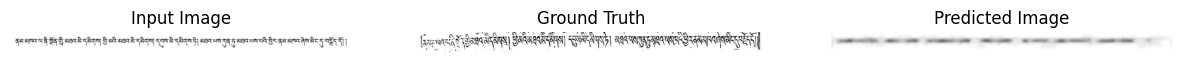

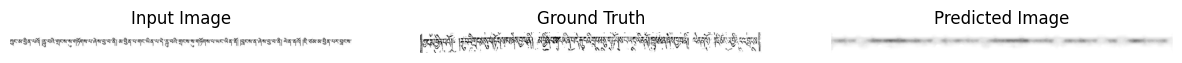

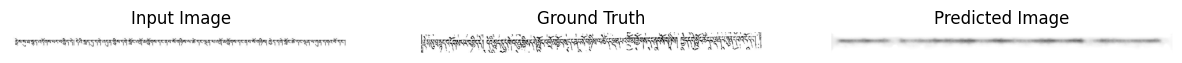

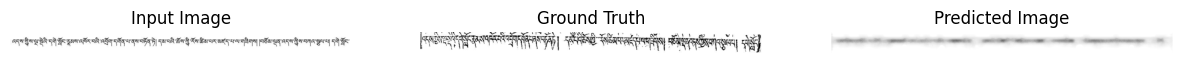

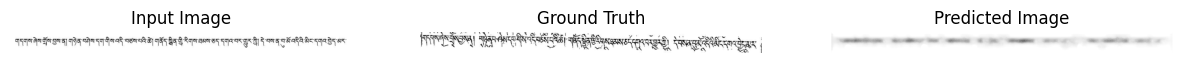

In [16]:
def evaluate_and_visualize(model, val_dataset, num_images=5):
    for i, (input_image, target) in enumerate(val_dataset.take(num_images)):
        generate_and_display_images(model.generator, input_image, target, i)
# Visualize the results on examples from the validation dataset
evaluate_and_visualize(pix2pix_model, val_dataset, num_images=5)
